<a href="https://colab.research.google.com/github/buwituze/HealthSpot_Model/blob/main/Summative_Intro_to_ml_%5BBenitha_Uwituze_Rutagengwa%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import xgboost as xgb
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')
!pip install rasterio
import rasterio
import os
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.9 MB/s eta 0:00:00


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


This project addresses healthcare accessibility in rural Rwanda by combining:
1. Health facility locations (572 facilities) with their coordinates and types
2. Population density data from satellite imagery (1km resolution)

Problem Statement:
Many rural areas in Rwanda have limited access to healthcare facilities. We need to:
- Identify underserved areas (high population, low healthcare access)
- Recommend optimal locations for new healthcare facilities

Classification Tasks:
1. Classify areas as "Low Access" vs "High Access" based on facility proximity and population
2. Classify potential locations as "Suitable" vs "Not Suitable" for new facilities

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_facilities = pd.read_csv("/content/drive/MyDrive/Summative_Dataset/Rwanda_Health_Facilities_Nature.csv")
print(f"Health facilities dataset shape: {df_facilities.shape}")
print(df_facilities.head())

print("Loading population density raster data...")
tif_path = "/content/drive/MyDrive/Summative_Dataset/rwa_pd_2020_1km.tif"

with rasterio.open(tif_path) as src:
    population_data = src.read(1)
    transform = src.transform
    bounds = src.bounds
    crs = src.crs

    print(f"Raster shape: {population_data.shape}")
    print(f"CRS: {crs}")
    print(f"Bounds: {bounds}")


Mounted at /content/drive
Health facilities dataset shape: (572, 11)
              X              Y Country Admin1                Facility_n  \
0  3.286786e+06 -276147.439641  Rwanda  South      Kigeme Health Centre   
1  3.385482e+06 -143692.220389  Rwanda   East  Bugaragara Health Centre   
2  3.336557e+06 -224310.470995  Rwanda  South      Kigese Health Centre   
3  3.377188e+06 -192979.510510  Rwanda   East    Bugarura Health Centre   
4  3.316508e+06 -251847.843673  Rwanda  South      Kigoma Health Centre   

      Facility_t Ownership     Lat     Long LL_source  ObjectId  
0  Health Centre    Public -2.4799  29.5257       GPS         1  
1  Health Centre    Public -1.2907  30.4123       GPS         2  
2  Health Centre    Public -2.0146  29.9728       GPS         3  
3  Health Centre    Public -1.7333  30.3378       GPS         4  
4  Health Centre    Public -2.2618  29.7927       GPS         5  
Loading population density raster data...
Raster shape: (215, 245)
CRS: EPSG:4326
Bo

In [ ]:
print("Converting raster to coordinate points...")
rows, cols = population_data.shape
grid_points = []

for row in range(0, rows, 5):
    for col in range(0, cols, 5):
        if population_data[row, col] > 0:
            lon, lat = rasterio.transform.xy(transform, row, col)
            pop_density = population_data[row, col]
            grid_points.append([lat, lon, pop_density])

grid_df = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude', 'Population_Density'])
print(f"Created {len(grid_df)} grid points with population data")

Converting raster to coordinate points...
Created 1036 grid points with population data


In [ ]:
def calculate_nearest_facility_distance(lat, lon, facilities_df):
    min_distance = float('inf')
    for _, facility in facilities_df.iterrows():
        if pd.notna(facility['Lat']) and pd.notna(facility['Long']):
            try:
                distance = geodesic((lat, lon), (facility['Lat'], facility['Long'])).kilometers
                min_distance = min(min_distance, distance)
            except:
                continue
    return min_distance if min_distance != float('inf') else 50

def count_facilities_in_radius(lat, lon, facilities_df, radius_km):
    count = 0
    for _, facility in facilities_df.iterrows():
        if pd.notna(facility['Lat']) and pd.notna(facility['Long']):
            try:
                distance = geodesic((lat, lon), (facility['Lat'], facility['Long'])).kilometers
                if distance <= radius_km:
                    count += 1
            except:
                continue
    return count

print("Calculating features...")
grid_df['Distance_to_Nearest_Facility'] = grid_df.apply(
    lambda row: calculate_nearest_facility_distance(row['Latitude'], row['Longitude'], df_facilities), axis=1
)

grid_df['Facilities_within_10km'] = grid_df.apply(
    lambda row: count_facilities_in_radius(row['Latitude'], row['Longitude'], df_facilities, 10), axis=1
)

grid_df['Facilities_within_5km'] = grid_df.apply(
    lambda row: count_facilities_in_radius(row['Latitude'], row['Longitude'], df_facilities, 5), axis=1
)

grid_df['Population_per_Facility_10km'] = grid_df['Population_Density'] / (grid_df['Facilities_within_10km'] + 1)
grid_df['Access_Score'] = (grid_df['Facilities_within_10km'] * 10 + grid_df['Facilities_within_5km'] * 20) / (grid_df['Distance_to_Nearest_Facility'] + 1)

print("Feature engineering completed!")
print(f"Final dataset shape: {grid_df.shape}")

Calculating features...
Feature engineering completed!
Final dataset shape: (1036, 8)


In [ ]:
print("Data distribution analysis:")
print(f"Distance stats: min={grid_df['Distance_to_Nearest_Facility'].min():.2f}, max={grid_df['Distance_to_Nearest_Facility'].max():.2f}")
print(f"Population stats: min={grid_df['Population_Density'].min():.2f}, max={grid_df['Population_Density'].max():.2f}")
print(f"Facilities within 10km stats: min={grid_df['Facilities_within_10km'].min()}, max={grid_df['Facilities_within_10km'].max()}")

distance_threshold = grid_df['Distance_to_Nearest_Facility'].quantile(0.6)
population_threshold = grid_df['Population_Density'].quantile(0.5)
facility_threshold = 2

grid_df['Low_Access'] = (
    (grid_df['Distance_to_Nearest_Facility'] > distance_threshold) |
    ((grid_df['Population_Density'] > population_threshold) &
     (grid_df['Facilities_within_10km'] <= facility_threshold))
).astype(int)

print(f"\nFinal class distribution:")
print(f"Low Access areas: {grid_df['Low_Access'].sum()} ({grid_df['Low_Access'].mean()*100:.1f}%)")
print(f"High Access areas: {(grid_df['Low_Access']==0).sum()} ({(1-grid_df['Low_Access'].mean())*100:.1f}%)")

if grid_df['Low_Access'].sum() < 10 or (grid_df['Low_Access']==0).sum() < 10:
    print("WARNING: Very imbalanced classes detected. Adjusting thresholds...")
    distance_threshold = grid_df['Distance_to_Nearest_Facility'].median()
    grid_df['Low_Access'] = (grid_df['Distance_to_Nearest_Facility'] > distance_threshold).astype(int)
    print(f"Adjusted class distribution:")
    print(f"Low Access areas: {grid_df['Low_Access'].sum()} ({grid_df['Low_Access'].mean()*100:.1f}%)")
    print(f"High Access areas: {(grid_df['Low_Access']==0).sum()} ({(1-grid_df['Low_Access'].mean())*100:.1f}%)")

feature_columns = [
    'Population_Density', 'Distance_to_Nearest_Facility',
    'Facilities_within_10km', 'Facilities_within_5km',
    'Population_per_Facility_10km', 'Access_Score'
]

X = grid_df[feature_columns]
y = grid_df['Low_Access']

print(f"Total samples: {len(y)}")
print(f"Class 0 (High Access): {(y==0).sum()}")
print(f"Class 1 (Low Access): {(y==1).sum()}")

Data distribution analysis:
Distance stats: min=0.02, max=23.14
Population stats: min=6.69, max=14170.92
Facilities within 10km stats: min=0, max=30

Final class distribution:
Low Access areas: 419 (40.4%)
High Access areas: 617 (59.6%)
Total samples: 1036
Class 0 (High Access): 617
Class 1 (Low Access): 419


In [ ]:
# Train/validation/test split with error handling
try:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    print("Stratified split successful!")
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Using random split instead...")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Test: {X_test.shape[0]}")
print(f"Train class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Stratified split successful!
Training: 621 | Validation: 207 | Test: 208
Train class distribution: [370 251]
Test class distribution: [124  84]


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


## MODEL 1: LOGISTIC REGRESSION (Classical ML)

In [ ]:
print("\n" + "="*50)
print("HealthSpot MODEL 1: LOGISTIC REGRESSION")
print("="*50)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("Training Logistic Regression with hyperparameter tuning...")
lr_grid.fit(X_train_scaled, y_train)

best_lr = lr_grid.best_estimator_
print(f"Best parameters: {lr_grid.best_params_}")
print(f"Best cross-validation F1 score: {lr_grid.best_score_:.4f}")

y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_proba_lr = best_lr.predict_proba(X_test_scaled)[:, 1]

os.makedirs('saved_models', exist_ok=True)
joblib.dump(best_lr, 'saved_models/1_logistic-regression.pkl')
print("Model saved as '1_logistic-regression.pkl' in saved_models folder")


MODEL 1: LOGISTIC REGRESSION
Training Logistic Regression with hyperparameter tuning...
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation F1 score: 0.9858
Model saved as '1_logistic-regression.pkl' in saved_models folder


## Print out the Final Model Accuracy and plot the Loss


Logistic Regression - EVALUATION RESULTS
----------------------------------------
Precision: 0.9882
Recall: 1.0000
F1-Score: 0.9941
ROC-AUC: 1.0000


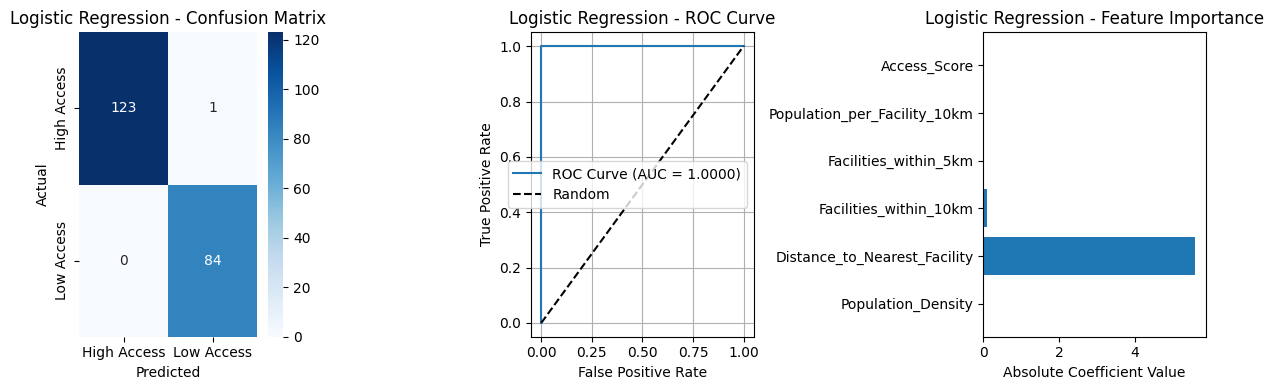

In [ ]:
# Evaluation and Plot

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{model_name} - EVALUATION RESULTS")
    print("-" * 40)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['High Access', 'Low Access'],
                yticklabels=['High Access', 'Low Access'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)

    if hasattr(best_lr, 'coef_'):
        plt.subplot(1, 3, 3)
        feature_importance = abs(best_lr.coef_[0])
        features = feature_columns
        plt.barh(features, feature_importance)
        plt.title(f'{model_name} - Feature Importance')
        plt.xlabel('Absolute Coefficient Value')

    plt.tight_layout()
    plt.show()

    return precision, recall, f1, roc_auc

lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr, "Logistic Regression")

## MODEL 2: SIMPLE NEURAL NETWORK (No Optimization)

In [ ]:
import os

print("\n" + "="*50)
print("HealthSpot MODEL 2: SIMPLE NEURAL NETWORK")
print("="*50)

def create_simple_model(input_dim):
    """Create simple neural network without optimization techniques"""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

simple_model = create_simple_model(X_train_scaled.shape[1])
print("Simple Neural Network Architecture:")
simple_model.summary()

print("Training simple neural network...")
history_simple = simple_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

os.makedirs('saved_models', exist_ok=True)
simple_model.save('saved_models/2_neural-network.h5')
print("Model saved as '2_neural-network.h5' in saved_models folder")


MODEL 2: SIMPLE NEURAL NETWORK
Simple Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Training simple neural network...
Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5871 - loss: 0.6875 - val_accuracy: 0.8406 - val_loss: 0.5546
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8385 - loss: 0.5072 - val_accuracy: 0.8889 - val_loss: 0.4221
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8975 - loss: 0.3778 - val_accuracy: 0.8937 - val_loss: 0.3089
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9330 - loss: 0.2707 - val_accuracy: 0.9034 - val_loss: 0.2287
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9517 - loss: 0.1961 - val_accuracy: 0.9565 - val_loss: 0.1766
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9624 - loss: 0.1474 - val_accuracy: 0.9662 - val_loss: 0.1440
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9710 - loss: 0.1173 - val_accuracy: 0.9807 - val_loss: 0.1240
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9742 - loss: 0.1

Model saved as '2_neural-network.h5' in saved_models folder


## Print out the Final Model Accuracy and plot the Loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Simple Neural Network - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


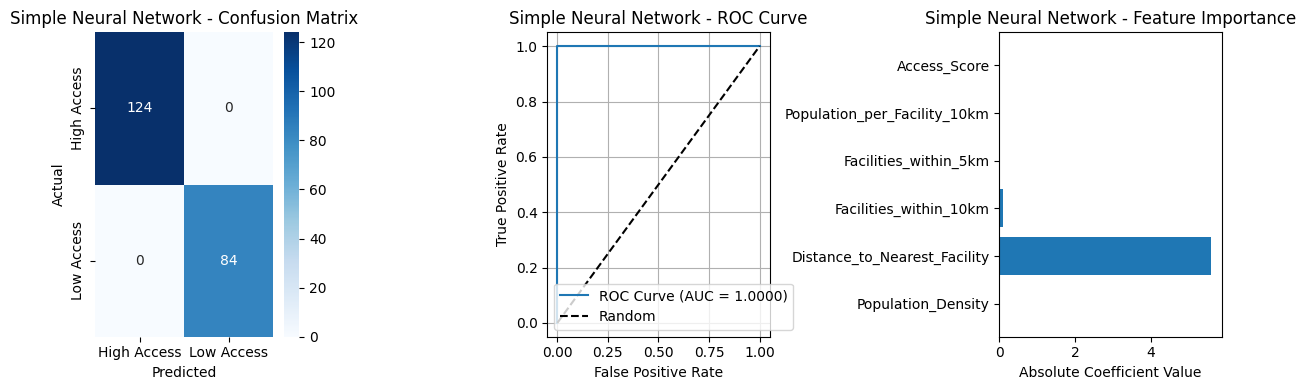

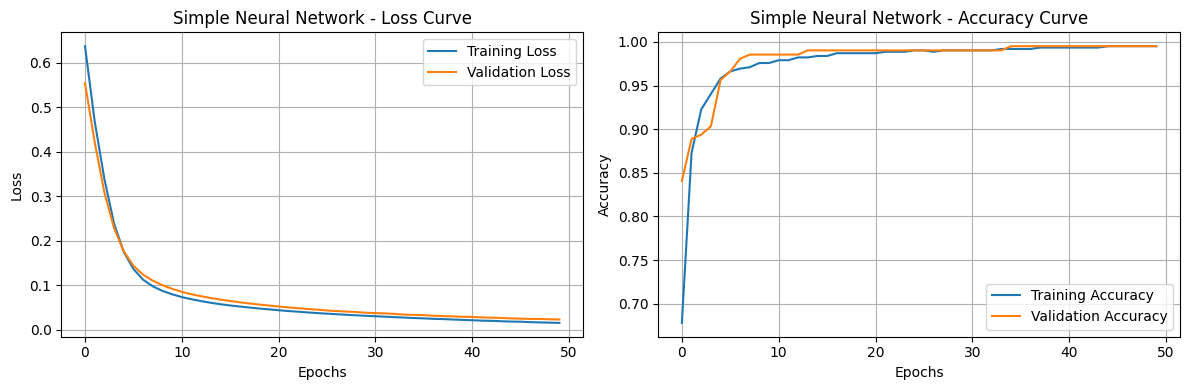

Model 1 (Logistic Regression) and Model 2 (Simple Neural Network) completed!


In [ ]:
# Evaluate and Plot

y_pred_simple = (simple_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_simple = simple_model.predict(X_test_scaled).flatten()

simple_metrics = evaluate_model(y_test, y_pred_simple, y_pred_proba_simple, "Simple Neural Network")

def plot_training_history(history, model_name):
    """Plot training and validation loss/accuracy"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_simple, "Simple Neural Network")

print("Model 1 (Logistic Regression) and Model 2 (Simple Neural Network) completed!")

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [ ]:
print("\n" + "="*50)
print("HealthSpot MODEL 3: NEURAL NETWORKS WITH OPTIMIZATION")
print("="*50)

import os
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

def create_optimized_model(input_dim, optimizer_config, regularizer=None, dropout_rate=0.0, num_layers=3, neurons=[64, 32, 16]):
    """
    Create neural network with specified optimization techniques

    Parameters:
    - input_dim: number of input features
    - optimizer_config: optimizer configuration (Adam, RMSprop, etc.)
    - regularizer: regularization technique (l1, l2, l1_l2)
    - dropout_rate: dropout rate for regularization
    - num_layers: number of hidden layers
    - neurons: list of neurons per layer
    """
    model = Sequential()

    if regularizer:
        model.add(Dense(neurons[0], activation='relu', input_dim=input_dim, kernel_regularizer=regularizer))
    else:
        model.add(Dense(neurons[0], activation='relu', input_dim=input_dim))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    for i in range(1, min(num_layers, len(neurons))):
        if regularizer:
            model.add(Dense(neurons[i], activation='relu', kernel_regularizer=regularizer))
        else:
            model.add(Dense(neurons[i], activation='relu'))

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizer_config,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_and_evaluate_instance(model, instance_name, epochs=100, early_stopping=False, verbose=1):
    """Train model instance and return history and metrics"""

    callbacks = []
    if early_stopping:
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        )
        callbacks.append(early_stop)

    print(f"\nTraining {instance_name}...")
    print(f"Model Architecture:")
    model.summary()

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=epochs,
        batch_size=32,
        verbose=verbose,
        callbacks=callbacks
    )

    model_path = f'saved_models/{instance_name.lower().replace(" ", "_")}.h5'
    model.save(model_path)
    print(f"Model saved to: {model_path}")

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    y_pred_proba = model.predict(X_test_scaled).flatten()

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    train_loss = history.history['loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]

    return history, {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }

all_histories = {}
all_metrics = {}
model_configs = {}


MODEL 3: NEURAL NETWORKS WITH OPTIMIZATION



------------------------------------------------------------
INSTANCE 1: Adam + L2 Regularization + Early Stopping
------------------------------------------------------------

Training Instance_1...
Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4815 - loss: 1.4265 - val_accuracy: 0.6860 - val_loss: 1.3007
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6870 - loss: 1.2730 - val_accuracy: 0.8454 - val_loss: 1.1728
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7782 - loss: 1.1289 - val_accuracy: 0.8551 - val_loss: 1.0418
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8064 - loss: 1.0178 - val_accuracy: 0.8357 - val_loss: 0.9140
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8592 - loss: 0.8923 - val_accuracy: 0.8357 - val_loss: 0.8064
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8630 - loss: 0.8037 - val_accuracy: 0.8502 - val_loss: 0.7203
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9041 - loss: 0.7008 - val_accuracy: 0.8696 - val_loss: 0.6420
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9161 - loss: 0.6366 - val_accuracy: 0.8937 - 

Model saved to: saved_models/instance_1.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Instance 1 - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 0.9881
F1-Score: 0.9940
ROC-AUC: 0.9999


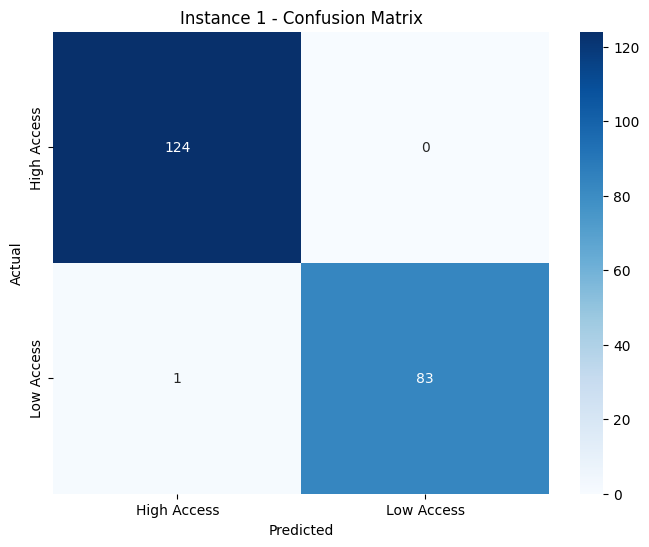

In [ ]:
# INSTANCE 1

print("\n" + "-"*60)
print("INSTANCE 1: Adam + L2 Regularization + Early Stopping")
print("-"*60)

optimizer_1 = Adam(learning_rate=0.001)
regularizer_1 = l2(0.01)

model_1 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_1,
    regularizer=regularizer_1,
    dropout_rate=0.3,
    num_layers=3,
    neurons=[64, 32, 16]
)

model_configs['Instance 1'] = {
    'Optimizer': 'Adam',
    'Learning Rate': 0.001,
    'Regularizer': 'L2 (0.01)',
    'Early Stopping': 'Yes',
    'Epochs': 100,
    'Layers': 3,
    'Dropout': 0.3
}

history_1, metrics_1 = train_and_evaluate_instance(
    model_1, "Instance_1", epochs=100, early_stopping=True, verbose=1
)

all_histories['Instance 1'] = history_1
all_metrics['Instance 1'] = metrics_1

y_pred_1 = (model_1.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_1 = model_1.predict(X_test_scaled).flatten()

print("\nInstance 1 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_1['precision']:.4f}")
print(f"Recall: {metrics_1['recall']:.4f}")
print(f"F1-Score: {metrics_1['f1']:.4f}")
print(f"ROC-AUC: {metrics_1['roc_auc']:.4f}")

cm_1 = confusion_matrix(y_test, y_pred_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 1 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


------------------------------------------------------------
INSTANCE 2: RMSprop + L1 Regularization + Different Learning Rate
------------------------------------------------------------

Training Instance_2...
Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7097 - loss: 3.4389 - val_accuracy: 0.9372 - val_loss: 0.8367
Epoch 2/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9210 - loss: 0.8131 - val_accuracy: 0.9517 - val_loss: 0.6938
Epoch 3/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9291 - loss: 0.7250 - val_accuracy: 0.9469 - val_loss: 0.6636
Epoch 4/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9376 - loss: 0.6992 - val_accuracy: 0.9517 - val_loss: 0.6337
Epoch 5/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9427 - loss: 0.6691 - val_accuracy: 0.9614 - val_loss: 0.6115
Epoch 6/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9517 - loss: 0.6308 - val_accuracy: 0.9758 - val_loss: 0.5605
Epoch 7/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9543 - loss: 0.6133 - val_accuracy: 0.9565 - val_loss: 0.5567
Epoch 8/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9637 - loss: 0.5759 - val_accuracy: 0.9469 - val_loss

Model saved to: saved_models/instance_2.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Instance 2 - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 0.8929
F1-Score: 0.9434
ROC-AUC: 1.0000


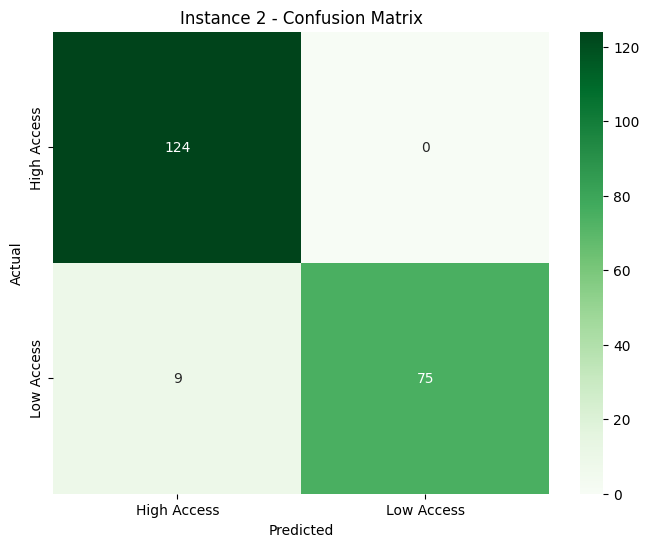

In [ ]:
# INSTANCE 2

print("\n" + "-"*60)
print("INSTANCE 2: RMSprop + L1 Regularization + Different Learning Rate")
print("-"*60)

optimizer_2 = RMSprop(learning_rate=0.01)
regularizer_2 = l1(0.005)

model_2 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_2,
    regularizer=regularizer_2,
    dropout_rate=0.2,
    num_layers=4,
    neurons=[128, 64, 32, 16]
)

model_configs['Instance 2'] = {
    'Optimizer': 'RMSprop',
    'Learning Rate': 0.01,
    'Regularizer': 'L1 (0.005)',
    'Early Stopping': 'No',
    'Epochs': 80,
    'Layers': 4,
    'Dropout': 0.2
}

history_2, metrics_2 = train_and_evaluate_instance(
    model_2, "Instance_2", epochs=80, early_stopping=False, verbose=1
)

all_histories['Instance 2'] = history_2
all_metrics['Instance 2'] = metrics_2

y_pred_2 = (model_2.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_2 = model_2.predict(X_test_scaled).flatten()

print("\nInstance 2 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_2['precision']:.4f}")
print(f"Recall: {metrics_2['recall']:.4f}")
print(f"F1-Score: {metrics_2['f1']:.4f}")
print(f"ROC-AUC: {metrics_2['roc_auc']:.4f}")

cm_2 = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Greens',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 2 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


------------------------------------------------------------
INSTANCE 3: Adam + L1_L2 Regularization + High Dropout + Early Stopping
------------------------------------------------------------

Training Instance_3...
Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 96)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,529 (25.50 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4594 - loss: 4.7669 - val_accuracy: 0.6280 - val_loss: 4.5134
Epoch 2/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5651 - loss: 4.4752 - val_accuracy: 0.7778 - val_loss: 4.2392
Epoch 3/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6454 - loss: 4.1756 - val_accuracy: 0.8068 - val_loss: 3.9798
Epoch 4/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6225 - loss: 3.9474 - val_accuracy: 0.8164 - val_loss: 3.7321
Epoch 5/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6727 - loss: 3.6847 - val_accuracy: 0.8213 - val_loss: 3.4958
Epoch 6/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7395 - loss: 3.4391 - val_accuracy: 0.8213 - val_loss: 3.2717
Epoch 7/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6976 - loss: 3.2393 - val_accuracy: 0.8357 - val_loss: 3.0571
Epoch 8/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7610 - loss: 3.0235 - val_accuracy: 0.83

Model saved to: saved_models/instance_3.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Instance 3 - EVALUATION RESULTS
----------------------------------------
Precision: 0.9882
Recall: 1.0000
F1-Score: 0.9941
ROC-AUC: 0.9997


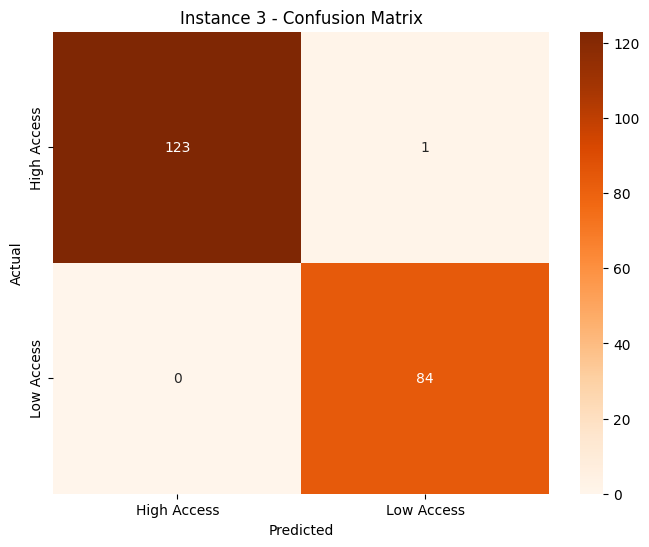

In [ ]:
# INSTANCE 3

print("\n" + "-"*60)
print("INSTANCE 3: Adam + L1_L2 Regularization + High Dropout + Early Stopping")
print("-"*60)

optimizer_3 = Adam(learning_rate=0.0005)
regularizer_3 = l1_l2(l1=0.005, l2=0.005)

model_3 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_3,
    regularizer=regularizer_3,
    dropout_rate=0.5,
    num_layers=3,
    neurons=[96, 48, 24]
)

model_configs['Instance 3'] = {
    'Optimizer': 'Adam',
    'Learning Rate': 0.0005,
    'Regularizer': 'L1_L2 (0.005, 0.005)',
    'Early Stopping': 'Yes',
    'Epochs': 120,
    'Layers': 3,
    'Dropout': 0.5
}

history_3, metrics_3 = train_and_evaluate_instance(
    model_3, "Instance_3", epochs=120, early_stopping=True, verbose=1
)

all_histories['Instance 3'] = history_3
all_metrics['Instance 3'] = metrics_3

y_pred_3 = (model_3.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_3 = model_3.predict(X_test_scaled).flatten()

print("\nInstance 3 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_3['precision']:.4f}")
print(f"Recall: {metrics_3['recall']:.4f}")
print(f"F1-Score: {metrics_3['f1']:.4f}")
print(f"ROC-AUC: {metrics_3['roc_auc']:.4f}")

cm_3 = confusion_matrix(y_test, y_pred_3)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 3 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


------------------------------------------------------------
INSTANCE 4: RMSprop + L2 Regularization + Minimal Dropout
------------------------------------------------------------

Training Instance_4...
Model Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8157 - loss: 0.5230 - val_accuracy: 0.8841 - val_loss: 0.3262
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9229 - loss: 0.2676 - val_accuracy: 0.9275 - val_loss: 0.2201
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9346 - loss: 0.1942 - val_accuracy: 0.9372 - val_loss: 0.1839
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9639 - loss: 0.1455 - val_accuracy: 0.9710 - val_loss: 0.1500
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9629 - loss: 0.1346 - val_accuracy: 0.9710 - val_loss: 0.1354
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9560 - loss: 0.1327 - val_accuracy: 0.9758 - val_loss: 0.1270
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9628 - loss: 0.1281 - val_accuracy: 0.9710 - val_loss: 0.1224
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9825 - loss: 0.1064 - val_accuracy: 0.9807 - val_loss

Model saved to: saved_models/instance_4.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Instance 4 - EVALUATION RESULTS
----------------------------------------
Precision: 0.9882
Recall: 1.0000
F1-Score: 0.9941
ROC-AUC: 1.0000


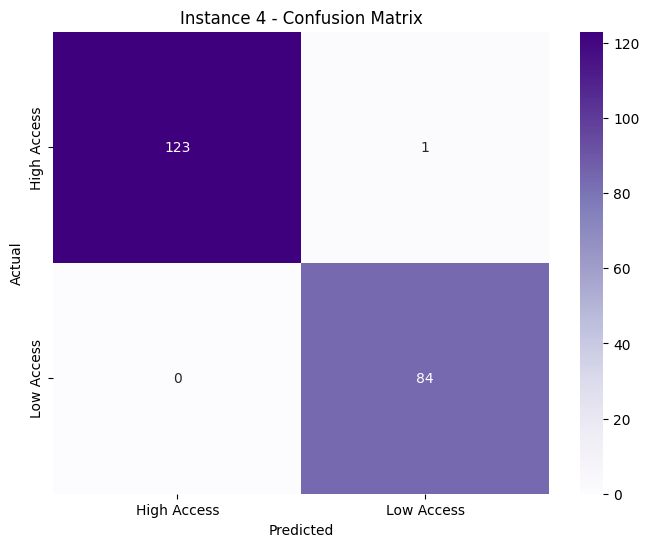

In [ ]:
# INSTANCE 4

print("\n" + "-"*60)
print("INSTANCE 4: RMSprop + L2 Regularization + Minimal Dropout")
print("-"*60)

optimizer_4 = RMSprop(learning_rate=0.005)
regularizer_4 = l2(0.001)

model_4 = create_optimized_model(
    input_dim=X_train_scaled.shape[1],
    optimizer_config=optimizer_4,
    regularizer=regularizer_4,
    dropout_rate=0.1,
    num_layers=2,
    neurons=[32, 16]
)

model_configs['Instance 4'] = {
    'Optimizer': 'RMSprop',
    'Learning Rate': 0.005,
    'Regularizer': 'L2 (0.001)',
    'Early Stopping': 'No',
    'Epochs': 60,
    'Layers': 2,
    'Dropout': 0.1
}

history_4, metrics_4 = train_and_evaluate_instance(
    model_4, "Instance_4", epochs=60, early_stopping=False, verbose=1
)

all_histories['Instance 4'] = history_4
all_metrics['Instance 4'] = metrics_4

y_pred_4 = (model_4.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_4 = model_4.predict(X_test_scaled).flatten()

print("\nInstance 4 - EVALUATION RESULTS")
print("-" * 40)
print(f"Precision: {metrics_4['precision']:.4f}")
print(f"Recall: {metrics_4['recall']:.4f}")
print(f"F1-Score: {metrics_4['f1']:.4f}")
print(f"ROC-AUC: {metrics_4['roc_auc']:.4f}")

cm_4 = confusion_matrix(y_test, y_pred_4)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_4, annot=True, fmt='d', cmap='Purples',
            xticklabels=['High Access', 'Low Access'],
            yticklabels=['High Access', 'Low Access'])
plt.title('Instance 4 - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


SIDE-BY-SIDE COMPARISON OF ALL INSTANCES


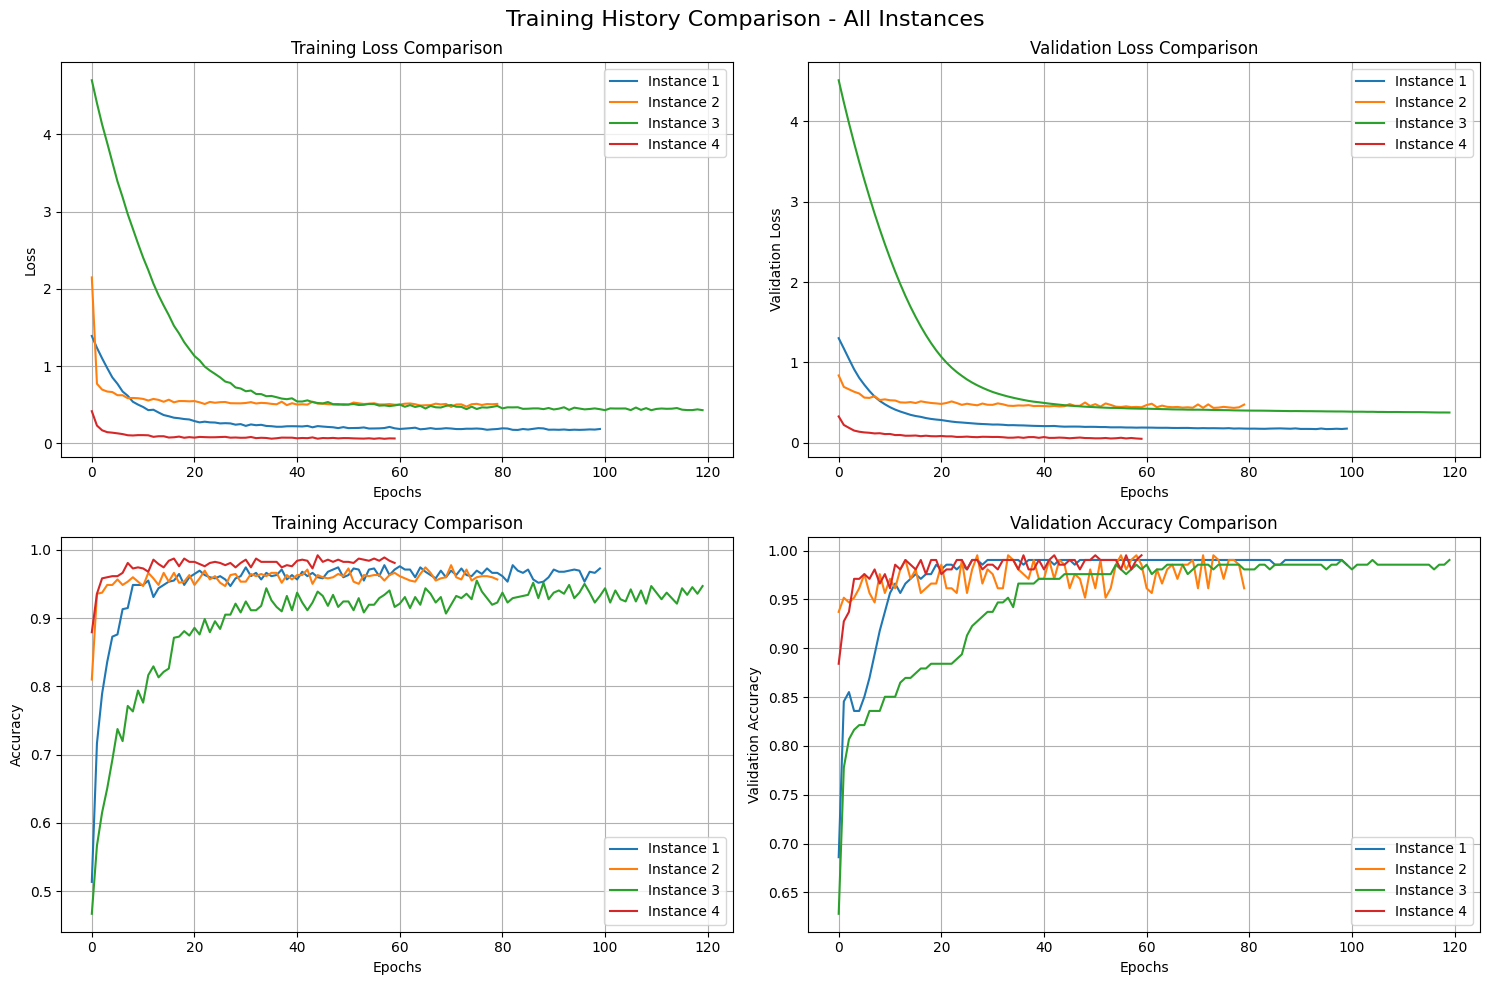


COMPREHENSIVE RESULTS TABLE
Training Instance Optimizer  Learning Rate          Regularizer Early Stopping  Epochs  Layers  Dropout Precision Recall F1-Score ROC-AUC Train Accuracy Val Accuracy
       Instance 1      Adam         0.0010            L2 (0.01)            Yes     100       3      0.3    1.0000 0.9881   0.9940  0.9999         0.9726       0.9855
       Instance 2   RMSprop         0.0100           L1 (0.005)             No      80       4      0.2    1.0000 0.8929   0.9434  1.0000         0.9565       0.9614
       Instance 3      Adam         0.0005 L1_L2 (0.005, 0.005)            Yes     120       3      0.5    0.9882 1.0000   0.9941  0.9997         0.9469       0.9903
       Instance 4   RMSprop         0.0050           L2 (0.001)             No      60       2      0.1    0.9882 1.0000   0.9941  1.0000         0.9807       0.9952

BEST PERFORMING INSTANCES:
Highest F1-Score: Instance 3 (F1: 0.9941)
Highest ROC-AUC: Instance 2 (ROC-AUC: 1.0000)


<Figure size 1200x800 with 0 Axes>

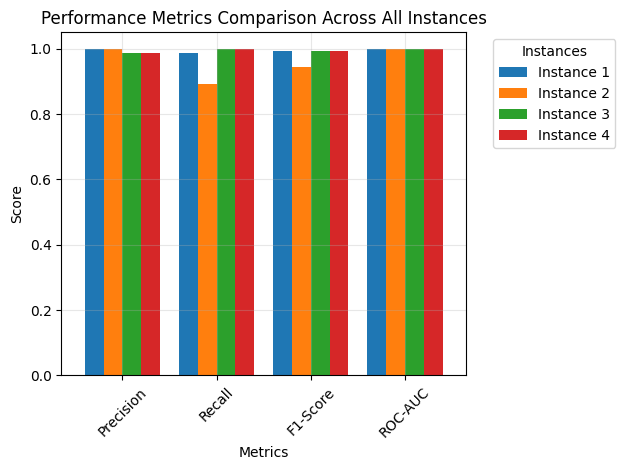


Model 3 with 4 optimization instances completed!
All models have been saved in the 'saved_models/' directory.


In [ ]:
# COMPARING ALL INSTANCES

print("\n" + "="*60)
print("SIDE-BY-SIDE COMPARISON OF ALL INSTANCES")
print("="*60)

def plot_all_training_histories(histories):
    """Plot training histories for all instances side by side"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training History Comparison - All Instances', fontsize=16)

    axes[0, 0].set_title('Training Loss Comparison')
    for name, history in histories.items():
        axes[0, 0].plot(history.history['loss'], label=f'{name}')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].set_title('Validation Loss Comparison')
    for name, history in histories.items():
        axes[0, 1].plot(history.history['val_loss'], label=f'{name}')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    axes[1, 0].set_title('Training Accuracy Comparison')
    for name, history in histories.items():
        axes[1, 0].plot(history.history['accuracy'], label=f'{name}')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].set_title('Validation Accuracy Comparison')
    for name, history in histories.items():
        axes[1, 1].plot(history.history['val_accuracy'], label=f'{name}')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_all_training_histories(all_histories)

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS TABLE")
print("="*80)

results_data = []
for instance, config in model_configs.items():
    metrics = all_metrics[instance]
    results_data.append({
        'Training Instance': instance,
        'Optimizer': config['Optimizer'],
        'Learning Rate': config['Learning Rate'],
        'Regularizer': config['Regularizer'],
        'Early Stopping': config['Early Stopping'],
        'Epochs': config['Epochs'],
        'Layers': config['Layers'],
        'Dropout': config['Dropout'],
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1']:.4f}",
        'ROC-AUC': f"{metrics['roc_auc']:.4f}",
        'Train Accuracy': f"{metrics['train_acc']:.4f}",
        'Val Accuracy': f"{metrics['val_acc']:.4f}"
    })

results_df = pd.DataFrame(results_data)
print(results_df.to_string(index=False))

best_f1_instance = max(all_metrics.keys(), key=lambda k: all_metrics[k]['f1'])
best_roc_instance = max(all_metrics.keys(), key=lambda k: all_metrics[k]['roc_auc'])

print(f"\nBEST PERFORMING INSTANCES:")
print(f"Highest F1-Score: {best_f1_instance} (F1: {all_metrics[best_f1_instance]['f1']:.4f})")
print(f"Highest ROC-AUC: {best_roc_instance} (ROC-AUC: {all_metrics[best_roc_instance]['roc_auc']:.4f})")

metrics_comparison = pd.DataFrame({
    instance: [metrics['precision'], metrics['recall'], metrics['f1'], metrics['roc_auc']]
    for instance, metrics in all_metrics.items()
}, index=['Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

plt.figure(figsize=(12, 8))
metrics_comparison.plot(kind='bar', width=0.8)
plt.title('Performance Metrics Comparison Across All Instances')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.legend(title='Instances', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nModel 3 with 4 optimization instances completed!")
print("All models have been saved in the 'saved_models/' directory.")

## MODEL 4: XGBoost with Hyperparameter Tuning and Rwanda Map Visualizations


MODEL 4: XGBoost WITH HYPERPARAMETER TUNING
Implementing XGBoost model with hyperparameter tuning...
Performing hyperparameter tuning with GridSearchCV...
This may take a few minutes...
Fitting 5 folds for each of 128 candidates, totalling 640 fits

Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation F1 score: 0.9920
XGBoost model saved to: saved_models/xgboost_model.pkl

XGBoost - EVALUATION RESULTS
----------------------------------------
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


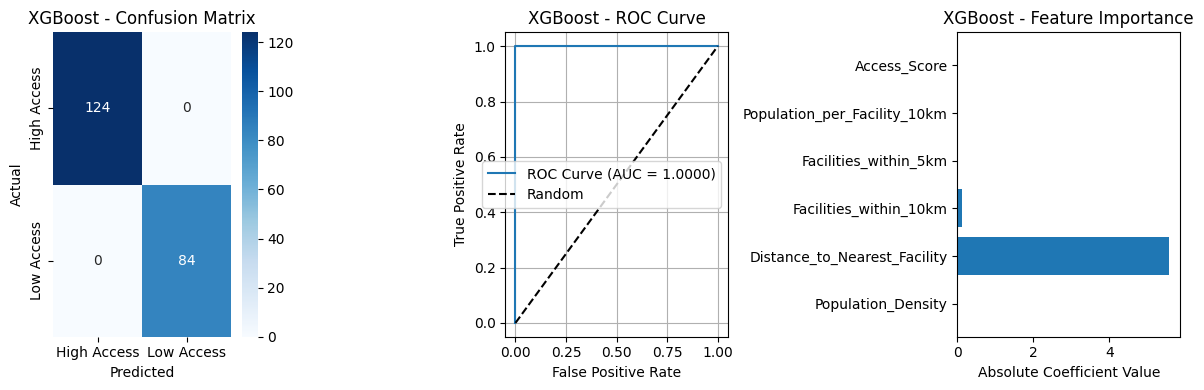

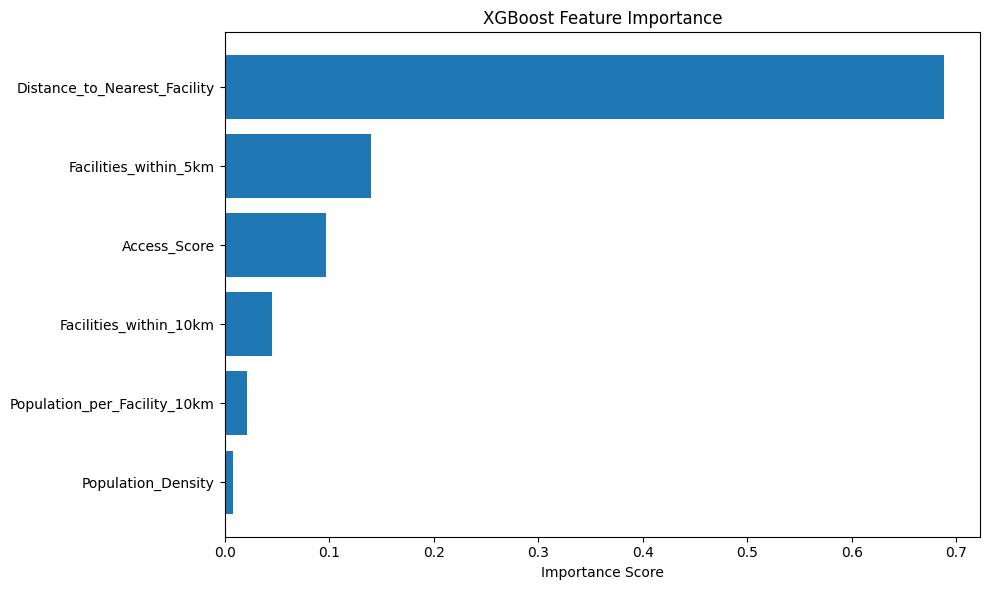


Top 3 Most Important Features:
1. Access_Score: 0.0972
1. Facilities_within_5km: 0.1396
1. Distance_to_Nearest_Facility: 0.6883


In [ ]:
print("\n" + "="*50)
print("HealthSpot MODEL 4: XGBoost WITH HYPERPARAMETER TUNING")
print("="*50)

import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Implementing XGBoost model with hyperparameter tuning...")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

print("Performing hyperparameter tuning with GridSearchCV...")
print("This may take a few minutes...")

reduced_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_grid = GridSearchCV(
    xgb_model,
    reduced_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_scaled, y_train)

best_xgb = xgb_grid.best_estimator_
print(f"\nBest XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation F1 score: {xgb_grid.best_score_:.4f}")

xgb_model_path = 'saved_models/xgboost_model.pkl'
import joblib
joblib.dump(best_xgb, xgb_model_path)
print(f"XGBoost model saved to: {xgb_model_path}")

y_pred_xgb = best_xgb.predict(X_test_scaled)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

xgb_metrics = evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb, "XGBoost")

feature_importance = best_xgb.feature_importances_
feature_names = feature_columns

plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print(f"\nTop 3 Most Important Features:")
top_features = importance_df.tail(3)
for idx, row in top_features.iterrows():
    print(f"1. {row['feature']}: {row['importance']:.4f}")

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):
    if model_path.endswith('.pkl'):
        model = joblib.load(model_path)
        predictions = model.predict(X)
    else:
        model = load_model(model_path)
        predictions = model.predict(X)
        predictions = (predictions > 0.5).astype(int).flatten()
    return predictions

In [ ]:
model_path = 'saved_models/1_logistic-regression.pkl'
lr_predictions = make_predictions(model_path, X_test_scaled)

model_path = 'saved_models/2_neural-network.h5'
nn_predictions = make_predictions(model_path, X_test_scaled)

print("Logistic Regression Results:")
lr_cm = confusion_matrix(y_test, lr_predictions)
lr_f1 = f1_score(y_test, lr_predictions)
print(f"Confusion Matrix:\n{lr_cm}")
print(f"F1 Score: {lr_f1:.4f}")

print("\nNeural Network Results:")
nn_cm = confusion_matrix(y_test, nn_predictions)
nn_f1 = f1_score(y_test, nn_predictions)
print(f"Confusion Matrix:\n{nn_cm}")
print(f"F1 Score: {nn_f1:.4f}")

# Select best model
if lr_f1 > nn_f1:
    best_model_path = 'saved_models/1_logistic-regression.pkl'
    print(f"\nBest Model: Logistic Regression (F1: {lr_f1:.4f})")
else:
    best_model_path = 'saved_models/2_neural-network.h5'
    print(f"\nBest Model: Neural Network (F1: {nn_f1:.4f})")

# Make predictions using best model
final_predictions = make_predictions(best_model_path, X_test_scaled)
print(f"\nFinal predictions using best model: {final_predictions[:10]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Logistic Regression Results:
Confusion Matrix:
[[123   1]
 [  0  84]]
F1 Score: 0.9941

Neural Network Results:
Confusion Matrix:
[[124   0]
 [  0  84]]
F1 Score: 1.0000

Best Model: Neural Network (F1: 1.0000)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Final predictions using best model: [1 1 1 0 0 0 1 0 0 0]


Congratulations!!
